In [1]:
import json
from pathlib import Path
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt

%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn

import model_utils
import plot_utils
import custom_transforms
from dataset import COCO_Person_Dataset
import Net from nn_model

In [ ]:
#17 keypoints
#'nose', 'left_eye', 'right_eye', 'left_ear', 'right_ear', 'left_shoulder', 'right_shoulder', 
#'left_elbow', 'right_elbow', 'left_wrist', 'right_wrist', 'left_hip', 'right_hip', 'left_knee', 
#'right_knee', 'left_ankle', 'right_ankle'

In [2]:
ds_categories = [{'supercategory': 'person', 'name': 'person', 'skeleton': [[16, 14], [14, 12], [17, 15], [15, 13], [12, 13], [6, 12], [7, 13], [6, 7], [6, 8], [7, 9], [8, 10], [9, 11], [2, 3], [1, 2], [1, 3], [2, 4], [3, 5], [4, 6], [5, 7]], 'keypoints': ['nose', 'left_eye', 'right_eye', 'left_ear', 'right_ear', 'left_shoulder', 'right_shoulder', 'left_elbow', 'right_elbow', 'left_wrist', 'right_wrist', 'left_hip', 'right_hip', 'left_knee', 'right_knee', 'left_ankle', 'right_ankle'], 'id': 1}]

img_id_to_annotations = np.load('im_id_to_keypoints.npy').ravel()[0]
img_id_to_image_info = np.load('img_id_to_annotation.npy').ravel()[0]
im_ids = list(img_id_to_annotations.keys())

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

import math
import skimage
import skimage.io as io
import skimage.transform, skimage.util
import numpy as np
from PIL import Image
from PIL import ImageOps

class Denorm(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
        
    def __call__(self, tensor):    
        return tensor.mul(self.std).add(self.mean)

class ResizeImgAndKeypoints(object):
    def __init__(self, size=224):
        self.size = size
            
    def __call__(self, sample):
        im = sample['image'] 
        keypoints = sample['keypoints'].copy() #2x17x3
        IM_H, IM_W = im.shape[:2] 
        if(IM_H > IM_W):
            w = int(self.size*IM_W/IM_H)
            h = self.size
            pad_val = int((self.size-w)/2)            
            pad = ((0,0), (self.size-w-pad_val,pad_val), (0,0))
        
            keypoints[:,:,0] = keypoints[:,:,0]*(w/IM_W)
            keypoints[:,:,0] += self.size-w-pad_val
            keypoints[:,:,1] = keypoints[:,:,1]*(self.size/IM_H)
            
        else:
            h = int(self.size*IM_H/IM_W)
            w = self.size
            pad_val = int((self.size-h)/2)
            pad = ((self.size-h-pad_val, pad_val), (0,0), (0,0))
        
            keypoints[:,:,0] = keypoints[:,:,0]*(self.size/IM_W)
            keypoints[:,:,1] = keypoints[:,:,1]*(h/IM_H)
            keypoints[:,:,1] += self.size-h-pad_val
        
        resized_img = skimage.transform.resize(im, (h,w), anti_aliasing=True)
        resized_img = skimage.util.pad(resized_img, pad_width=pad, mode='constant')
        return { 'image' : resized_img , 'keypoints' : keypoints }
    
    
class RandomFlipImgAndBbox(object):    
    def __call__(self, sample):
        img = sample['image']
        bbox = sample['bbox']
        
        if np.random.random() > 0.5:
            img = img.transpose(Image.FLIP_LEFT_RIGHT)
            w, h = img.size
            #bbox format (top left corner, bottom right corner) [y1, x1, y2, x2]
            copy = int(bbox[1])
            
            bbox[1] = w - bbox[3]
            bbox[3] = w - copy
        return { 'image' : img, 'bbox' : bbox }
    
class RandomRotateImgAndBbox(object):
    def __init__(self, deg):
        self.deg = deg
    
    def __rotate__(self, origin, point, deg):
        ox, oy = origin
        px, py = point
        theta = math.radians(-deg) #-deg since we measure y,x from top left and not w/2,h/2
        
        qx = math.cos(theta)*(px - ox) - math.sin(theta)*(py - oy)
        qy = math.sin(theta)*(px - ox) + math.cos(theta)*(py - oy)
        
        qx = qx + ox
        qy = qy + oy
        return int(qx), int(qy)
    
    def __call__(self, sample):
        img = sample['image']
        bbox_arr = sample['bbox']
        
        rand_deg = np.random.randint(-1*self.deg, self.deg+1)
        img = img.rotate(rand_deg)
        
        #bbox format (top left corner, bottom right corner) [y1, x1, y2, x2]
        bbox = bbox_arr.copy()
        y1, x1, y2, x2 = bbox_arr
        w, h = img.size
        bbox[1], bbox[0] = self.__rotate__((w/2, h/2), (x1, y1), rand_deg)
        bbox[3], bbox[2] = self.__rotate__((w/2, h/2), (x2, y2), rand_deg)
        return { 'image' : img, 'bbox' : bbox }
    
class ColorJitter(object):
    def __init__(self, brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1):
        self.tfm = transforms.ColorJitter(brightness=brightness, contrast=contrast, saturation=saturation, hue=hue)
        
    def __call__(self, sample):
        img = self.tfm(sample['image'])
        return { 'image' : img, 'bbox': sample['bbox'] }
    
class ImgAndBboxToTensor(object):        
    def __init__(self):
        self.ToTensor = transforms.ToTensor()
        
    def __call__(self, sample):        
        return { 'image' : self.ToTensor(sample['image']), 'bbox' : torch.tensor(sample['bbox'], dtype=torch.float) }      

In [4]:
ds = COCO_Person_Dataset('train2014/', img_id_to_image_info, img_id_to_annotations, ResizeImgAndKeypoints())

In [5]:
i, hm, paf, hm_ind, paf_ind = ds[0]

/Users/dhruv/miniconda3/envs/fastai-cpu/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [6]:
i.shape

(224, 224, 3)

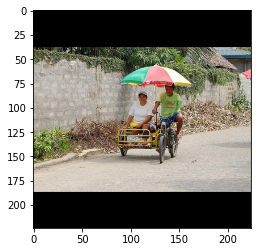

In [7]:
plt.imshow(i)

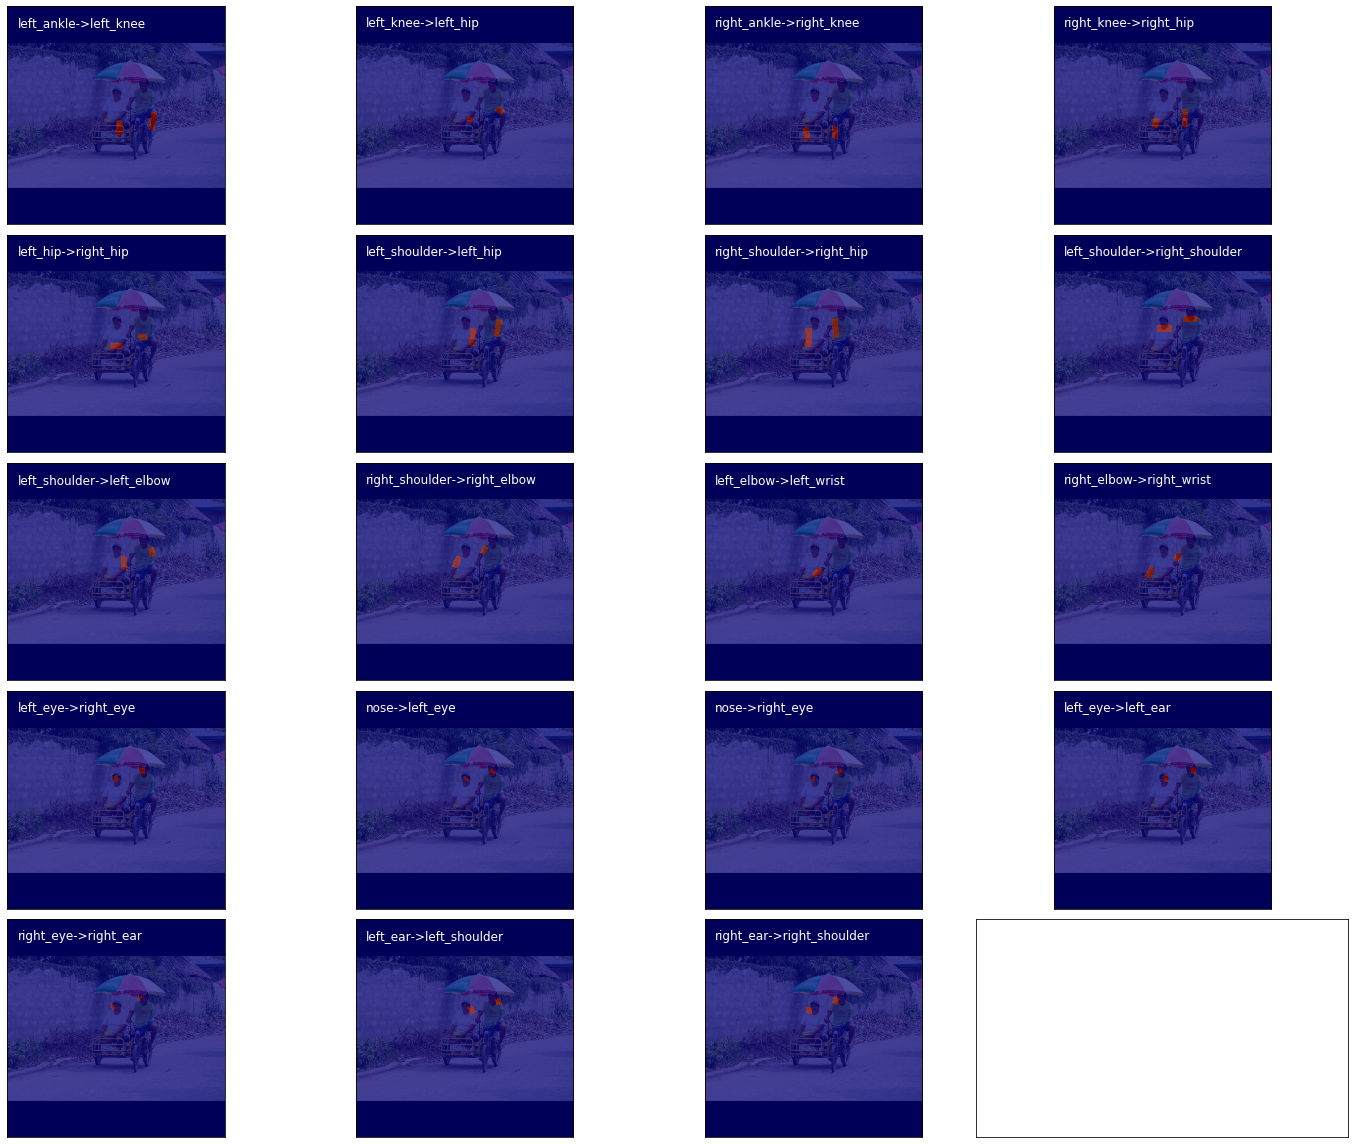

In [8]:
plot_utils.plot_pafs(i, paf,figsize=(20,16))

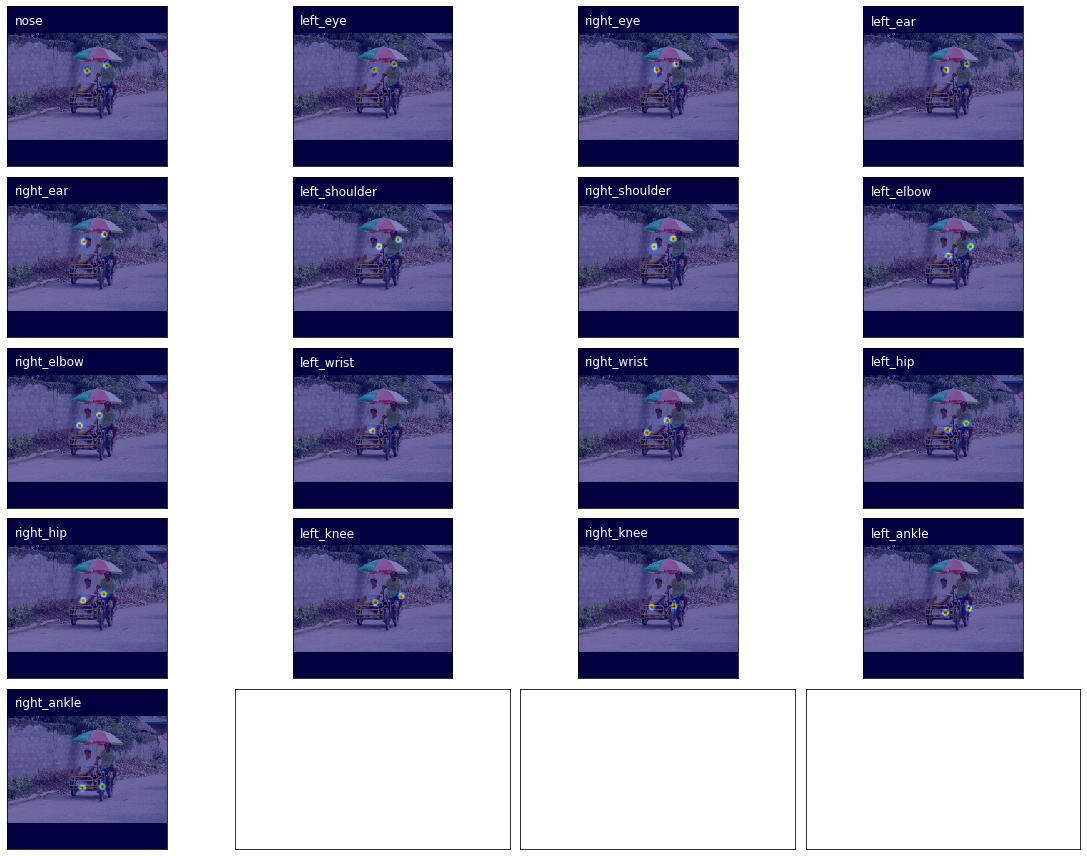

In [9]:
plot_utils.plot_heatmaps(i, hm)

In [98]:
model = Net(in_training=True)

In [99]:
model.freeze_F()

In [62]:
model.train_paf_stage(4)

In [100]:
model.freeze_all_paf_stages()

In [109]:
model.train_hm_stage(2)

In [111]:
paf, hm = model(torch.ones(1,3,224,224))

In [112]:
len(paf)

1

In [113]:
paf[0].shape

torch.Size([128, 28, 28])

In [54]:
pafs, heatmaps = model(torch.ones(1,3,224,224))